In [36]:
import pandas as pd

DATA_PATH = "data/final_data.csv"   # exakt dieselbe Datei wie in der GUI

df = pd.read_csv(DATA_PATH, parse_dates=["t10"])

# sanity check
df.columns


Index(['t10', 'location_id', 'estimated_seats', 'freeseats', 'manual_count',
       'freeseats_manual', 'numberofclients', 'longname', 'availableseats',
       'Opening', 'Closing', 'building_id', 'is_hill',
       'relative_availability'],
      dtype='object')

In [52]:
import pandas as pd
from seatadvisor_V3 import load_priors_csv

PRIORS_PATH = "priors.csv"   # ggf. Pfad anpassen

priors_dict, acc_dict = load_priors_csv(PRIORS_PATH)

# optional sanity check
list(priors_dict.items())[:3]


[(3, {'reach': 1.0, 'air': 0.4, 'light': 0.8, 'outlet': 0.4}),
 (4, {'reach': 0.7, 'air': 0.6, 'light': 1.0, 'outlet': 0.6}),
 (5, {'reach': 0.7, 'air': 1.0, 'light': 0.8, 'outlet': 0.8})]

In [38]:
SCENARIO = dict(
    campuses=[0, 1],
    weekday=None,
    time_of_day="afternoon",
    exam_period=True,
    availability_threshold=0.15,
    user_is_hill=0,
    require_accessible=False,
    prior_weights=(0.25, 0.25, 0.25, 0.25),
)


In [39]:
from seatadvisor_V3 import seat_advisor_locations

res = seat_advisor_locations(
    data=df,
    priors=priors_dict,
    acc=acc_dict,
    min_obs=200,
    topn=3,          # z.B. 3 Beispiel-Locations wie in deinem Bild
    **SCENARIO,
)

res[[
    "location_name",
    "capacity_stress_index",
    "mean_relative_availability",
    "sigma_norm",
    "location_id"
]]


,location_name,capacity_stress_index,mean_relative_availability,sigma_norm,location_id
0,"Alte Waschhalle, hinten",0.003127,0.744228,0.395357,16
1,"Ammerbau, Ebene 6, Rechts",0.130891,0.442010,0.484999,14
2,"Ammerbau, Ebene 6, Mitte",0.160003,0.432057,0.523369,13


In [40]:
df.head()


,t10,location_id,estimated_seats,freeseats,manual_count,freeseats_manual,numberofclients,longname,availableseats,Opening,Closing,building_id,is_hill,relative_availability
0,2016-04-12 13:00:00,3,NaN,NaN,NaN,NaN,32,"Historischer Lesesaal, Bonatzbau, EG",64,08:00:00,20:00:00,4,0,NaN
1,2016-04-12 13:00:00,4,NaN,NaN,NaN,NaN,16,"Ammerbau, Ebene 3, Links",29,08:00:00,00:00:00,1,0,NaN
2,2016-04-12 13:00:00,5,NaN,NaN,NaN,NaN,41,"Ammerbau, Ebene 3, Rechts",158,08:00:00,00:00:00,1,0,NaN
3,2016-04-12 13:00:00,6,NaN,NaN,NaN,NaN,21,"Ammerbau, Ebene 4, Links",42,08:00:00,00:00:00,1,0,NaN
4,2016-04-12 13:00:00,7,NaN,NaN,NaN,NaN,16,"Ammerbau, Ebene 4, Mitte",27,08:00:00,00:00:00,1,0,NaN


In [41]:
import numpy as np

scorecard = pd.DataFrame({
    "Location": res["location_name"].values,

    # aus SeatAdvisor
    "Inv_CSI": 1.0 - res["capacity_stress_index"].values,
    "Availability": res["mean_relative_availability"].values,
    "Predictability": 1.0 - res["sigma_norm"].values,

    # aus priors.csv
    "Light": res["location_id"].map(
        lambda i: priors_dict[int(i)]["light"]
    ).values,
    "Air": res["location_id"].map(
        lambda i: priors_dict[int(i)]["air"]
    ).values,
    "Outlets": res["location_id"].map(
        lambda i: priors_dict[int(i)]["outlet"]
    ).values,
})

scorecard = scorecard.set_index("Location").clip(0, 1)
scorecard


,Inv_CSI,Availability,Predictability,Light,Air,Outlets
Location,,,,,,
"Alte Waschhalle, hinten",0.996873,0.744228,0.604643,0.6,0.3,0.1
"Ammerbau, Ebene 6, Rechts",0.869109,0.442010,0.515001,1.0,0.8,0.7
"Ammerbau, Ebene 6, Mitte",0.839997,0.432057,0.476631,1.0,0.8,0.7


In [53]:
import pandas as pd

DATA_PATH = "data/final_data.csv"   # exakt dieselbe Datei wie in der GUI

df = pd.read_csv(DATA_PATH, parse_dates=["t10"])

# sanity check
df.columns


Index(['t10', 'location_id', 'estimated_seats', 'freeseats', 'manual_count',
       'freeseats_manual', 'numberofclients', 'longname', 'availableseats',
       'Opening', 'Closing', 'building_id', 'is_hill',
       'relative_availability'],
      dtype='object')

In [59]:
import matplotlib as mpl
import numpy as np

def pastelize_cmap(cmap_name="RdYlGn", factor=0.45):
    """
    factor in [0,1]: higher = more pastel
    """
    base = mpl.cm.get_cmap(cmap_name, 256)
    colors = base(np.linspace(0, 1, 256))
    colors[:, :3] = colors[:, :3] + (1 - colors[:, :3]) * factor
    return mpl.colors.ListedColormap(colors)


Matched locations (ID -> name):
 location_id                              location_name      building_name
           3       Historischer Lesesaal, Bonatzbau, EG          Bonatzbau
          10                   Ammerbau, Ebene 5, Mitte           Ammerbau
          12                   Ammerbau, Ebene 6, Links           Ammerbau
          16                    Alte Waschhalle, hinten         Waschhalle
          17 Bereichsbibliothek Naturwissenschaften, EG Bereichsbibliothek
          19                         PCB-Bibliothek, UG                PCB

Color normalization info:
  Final score max among selected locations: 0.524 (colors use Final/final_max)
  SAS score max among selected locations:   0.582 (colors use SAS/sas_max)


/var/folders/st/_29vlc0158l324jr2qbhlz3w0000gn/T/ipykernel_29929/2219496794.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = mpl.cm.get_cmap(cmap_name, 256)


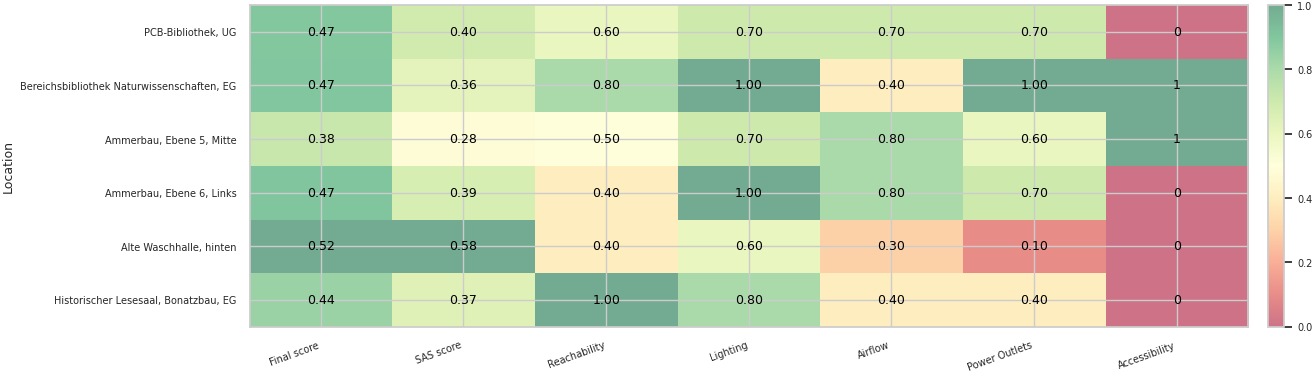

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tueplots import bundles
from seatadvisor_V3 import seat_advisor_locations

# -----------------------------
# Helper: pastel red -> green colormap
# -----------------------------
def pastelize_cmap(cmap_name: str = "RdYlGn", factor: float = 0.45) -> mpl.colors.ListedColormap:
    """
    factor in [0,1]: higher = more pastel (brighter / less saturated)
    """
    base = mpl.cm.get_cmap(cmap_name, 256)
    colors = base(np.linspace(0, 1, 256))
    colors[:, :3] = colors[:, :3] + (1 - colors[:, :3]) * factor
    return mpl.colors.ListedColormap(colors)

# -----------------------------
# User config
# -----------------------------
SELECTED_IDS = [19, 17, 10, 12, 16, 3, ]  # PCB UG, Bereichsbibliothek (hill) + Ammerbau/Waschhalle (valley)

SCENARIO = dict(
    campuses=[0, 1],
    weekday=None,               # any weekday
    time_of_day=None,           # any time of day
    exam_period=True,           # set False if you want non-exam weeks
    availability_threshold=0.15,
    user_is_hill=None,          # no distance penalty
    require_accessible=False,
    prior_weights=(0.25, 0.25, 0.25, 0.25),  # equal prior weights; lambda fixed in code (0.25)
)

MIN_OBS = 200

# -----------------------------
# 1) Run SeatAdvisor once
# -----------------------------
res_all = seat_advisor_locations(
    data=df,             # must contain t10, building_id, location_id, is_hill, relative_availability
    priors=priors_dict,  # from load_priors_csv("priors.csv")
    acc=acc_dict,        # from load_priors_csv("priors.csv")
    min_obs=MIN_OBS,
    topn=None,
    **SCENARIO,
)

# -----------------------------
# 2) Filter to selected locations and sanity checks
# -----------------------------
res = res_all[res_all["location_id"].isin(SELECTED_IDS)].copy()

print("Matched locations (ID -> name):")
print(
    res[["location_id", "location_name", "building_name"]]
    .sort_values("location_id")
    .to_string(index=False)
)

missing = [i for i in SELECTED_IDS if i not in set(res["location_id"])]
if missing:
    raise ValueError(
        f"These location_ids were not returned (likely < min_obs={MIN_OBS} under the chosen scenario): {missing}\n"
        f"Try lowering min_obs or changing exam_period."
    )

# Enforce the order specified by SELECTED_IDS
id_to_name = res.set_index("location_id")["location_name"].to_dict()
ordered_names = [id_to_name[i] for i in SELECTED_IDS]
res = res.set_index("location_name").loc[ordered_names].reset_index()

# -----------------------------
# 3) Build scorecard (true values)
# -----------------------------
scorecard = pd.DataFrame({
    "Location": res["location_name"].astype(str).values,

    # core scores
    "Final score": res["final_score"].astype(float).values,
    "SAS score":   res["sas_score"].astype(float).values,

    # priors (0..1, from priors.csv)
    "Reachability":  res["location_id"].map(lambda i: float(priors_dict[int(i)]["reach"])).values,
    "Lighting":      res["location_id"].map(lambda i: float(priors_dict[int(i)]["light"])).values,
    "Airflow":       res["location_id"].map(lambda i: float(priors_dict[int(i)]["air"])).values,
    "Power Outlets": res["location_id"].map(lambda i: float(priors_dict[int(i)]["outlet"])).values,

    # accessibility strictly 0/1
    "Accessibility": res["location_id"].map(lambda i: int(acc_dict.get(int(i), 0))).values,
}).set_index("Location")

# Ensure ranges / types (Final & SAS might not hit 1.0; keep true values unchanged here)
cont_cols = ["Final score", "SAS score", "Reachability", "Lighting", "Airflow", "Power Outlets"]
scorecard[cont_cols] = scorecard[cont_cols].apply(pd.to_numeric, errors="coerce").clip(0, 1)
scorecard["Accessibility"] = scorecard["Accessibility"].astype(int).clip(0, 1)

# -----------------------------
# 4) Build plot values for coloring (normalize Final & SAS to their own max, for comparable color use)
#    IMPORTANT: Annotations still show true values from scorecard.
# -----------------------------
plot_vals = scorecard.to_numpy(dtype=float).copy()
cols = list(scorecard.columns)

def _normalize_column_inplace(arr: np.ndarray, col_index: int) -> float:
    mx = float(np.nanmax(arr[:, col_index]))
    if mx > 0:
        arr[:, col_index] = arr[:, col_index] / mx
    return mx

final_idx = cols.index("Final score")
sas_idx   = cols.index("SAS score")

final_max = _normalize_column_inplace(plot_vals, final_idx)
sas_max   = _normalize_column_inplace(plot_vals, sas_idx)

# (priors already 0..1, accessibility 0/1; leave them as-is)

# -----------------------------
# 5) Plot heatmap (pastel red -> green)
# -----------------------------
plt.rcParams.update(bundles.neurips2023())
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "DejaVu Sans",
})

cmap = pastelize_cmap("RdYlGn", factor=0.45)

fig, ax = plt.subplots(figsize=(13.2, 3.8), layout="constrained")
im = ax.imshow(plot_vals, cmap=cmap, vmin=0, vmax=1, aspect="auto")

#ax.set_title("SeatAdvisor scorecard (any weekday/time; λ=0.25; pastel red → green)")
ax.set_ylabel("Location")

ax.set_xticks(range(scorecard.shape[1]))
ax.set_xticklabels(scorecard.columns, rotation=20, ha="right")

ax.set_yticks(range(scorecard.shape[0]))
ax.set_yticklabels(scorecard.index)

# annotate with TRUE values (not normalized)
for i in range(scorecard.shape[0]):
    for j in range(scorecard.shape[1]):
        v_true = scorecard.values[i, j]
        if np.isfinite(v_true):
            col = scorecard.columns[j]
            if col == "Accessibility":
                label = f"{int(v_true)}"
            else:
                label = f"{v_true:.2f}"
            ax.text(j, i, label, ha="center", va="center", color="black", fontsize=9)

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
#cbar.set_label("Color scale: 0–1 (red → green). SAS & Final are color-normalized by their column maxima.")

# Optional note in the console (useful for caption/methods)
print(f"\nColor normalization info:")
print(f"  Final score max among selected locations: {final_max:.3f} (colors use Final/final_max)")
print(f"  SAS score max among selected locations:   {sas_max:.3f} (colors use SAS/sas_max)")

plt.show()


Matched locations (ID -> name):
 location_id                              location_name      building_name
           3       Historischer Lesesaal, Bonatzbau, EG          Bonatzbau
          10                   Ammerbau, Ebene 5, Mitte           Ammerbau
          12                   Ammerbau, Ebene 6, Links           Ammerbau
          16                    Alte Waschhalle, hinten         Waschhalle
          17 Bereichsbibliothek Naturwissenschaften, EG Bereichsbibliothek
          19                         PCB-Bibliothek, UG                PCB


/var/folders/st/_29vlc0158l324jr2qbhlz3w0000gn/T/ipykernel_29929/3794924915.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = mpl.cm.get_cmap(cmap_name, 256)


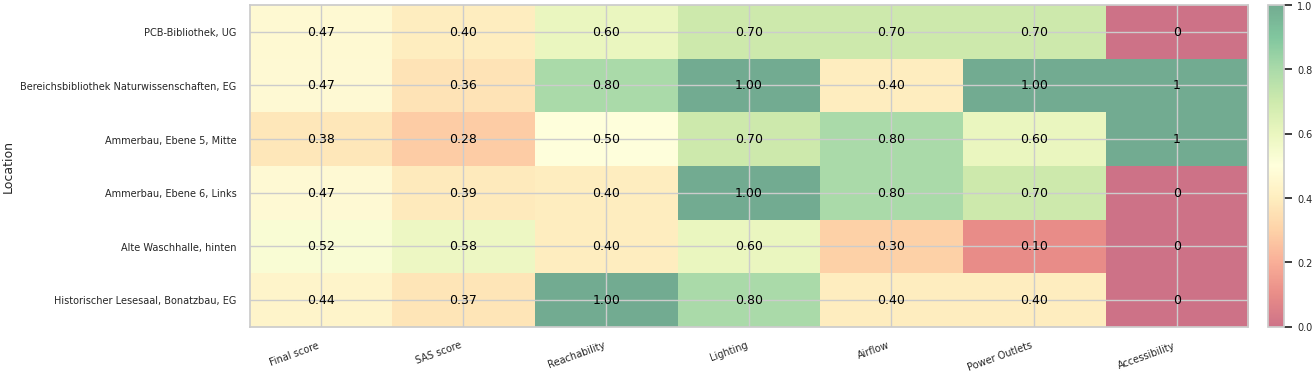

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tueplots import bundles
from seatadvisor_V3 import seat_advisor_locations

# -----------------------------
# Helper: pastel red -> green colormap
# -----------------------------
def pastelize_cmap(cmap_name: str = "RdYlGn", factor: float = 0.45) -> mpl.colors.ListedColormap:
    """
    factor in [0,1]: higher = more pastel (brighter / less saturated)
    """
    base = mpl.cm.get_cmap(cmap_name, 256)
    colors = base(np.linspace(0, 1, 256))
    colors[:, :3] = colors[:, :3] + (1 - colors[:, :3]) * factor
    return mpl.colors.ListedColormap(colors)

# -----------------------------
# User config
# -----------------------------
SELECTED_IDS = [19, 17, 10, 12, 16, 3]  # add/remove IDs as needed

SCENARIO = dict(
    campuses=[0, 1],
    weekday=None,               # any weekday
    time_of_day=None,           # any time of day
    exam_period=True,           # set False if you want non-exam weeks
    availability_threshold=0.15,
    user_is_hill=None,          # no distance penalty
    require_accessible=False,
    prior_weights=(0.25, 0.25, 0.25, 0.25),  # equal prior weights; lambda fixed in code (0.25)
)

MIN_OBS = 200

# -----------------------------
# 1) Run SeatAdvisor once
# -----------------------------
res_all = seat_advisor_locations(
    data=df,             # must contain t10, building_id, location_id, is_hill, relative_availability
    priors=priors_dict,  # from load_priors_csv("priors.csv")
    acc=acc_dict,        # from load_priors_csv("priors.csv")
    min_obs=MIN_OBS,
    topn=None,
    **SCENARIO,
)

# -----------------------------
# 2) Filter to selected locations and sanity checks
# -----------------------------
res = res_all[res_all["location_id"].isin(SELECTED_IDS)].copy()

print("Matched locations (ID -> name):")
print(
    res[["location_id", "location_name", "building_name"]]
    .sort_values("location_id")
    .to_string(index=False)
)

missing = [i for i in SELECTED_IDS if i not in set(res["location_id"])]
if missing:
    raise ValueError(
        f"These location_ids were not returned (likely < min_obs={MIN_OBS} under the chosen scenario): {missing}\n"
        f"Try lowering min_obs or changing exam_period."
    )

# Enforce the order specified by SELECTED_IDS
id_to_name = res.set_index("location_id")["location_name"].to_dict()
ordered_names = [id_to_name[i] for i in SELECTED_IDS]
res = res.set_index("location_name").loc[ordered_names].reset_index()

# -----------------------------
# 3) Build scorecard (true values; NO per-column normalization)
# -----------------------------
scorecard = pd.DataFrame({
    "Location": res["location_name"].astype(str).values,

    # core scores
    "Final score": res["final_score"].astype(float).values,
    "SAS score":   res["sas_score"].astype(float).values,

    # priors (0..1, from priors.csv)
    "Reachability":  res["location_id"].map(lambda i: float(priors_dict[int(i)]["reach"])).values,
    "Lighting":      res["location_id"].map(lambda i: float(priors_dict[int(i)]["light"])).values,
    "Airflow":       res["location_id"].map(lambda i: float(priors_dict[int(i)]["air"])).values,
    "Power Outlets": res["location_id"].map(lambda i: float(priors_dict[int(i)]["outlet"])).values,

    # accessibility strictly 0/1
    "Accessibility": res["location_id"].map(lambda i: int(acc_dict.get(int(i), 0))).values,
}).set_index("Location")

# Ensure ranges / types (keep true values; just clip to [0,1] for safety)
cont_cols = ["Final score", "SAS score", "Reachability", "Lighting", "Airflow", "Power Outlets"]
scorecard[cont_cols] = scorecard[cont_cols].apply(pd.to_numeric, errors="coerce").clip(0, 1)
scorecard["Accessibility"] = scorecard["Accessibility"].astype(int).clip(0, 1)

# Plot values are the true values (no normalization)
plot_vals = scorecard.to_numpy(dtype=float)

# -----------------------------
# 4) Plot heatmap (pastel red -> green)
# -----------------------------
plt.rcParams.update(bundles.neurips2023())
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "DejaVu Sans",
})

cmap = pastelize_cmap("RdYlGn", factor=0.45)

fig, ax = plt.subplots(figsize=(13.2, 3.8), layout="constrained")
im = ax.imshow(plot_vals, cmap=cmap, vmin=0, vmax=1, aspect="auto")

# ax.set_title("SeatAdvisor scorecard (any weekday/time; λ=0.25; pastel red → green)")
ax.set_ylabel("Location")

ax.set_xticks(range(scorecard.shape[1]))
ax.set_xticklabels(scorecard.columns, rotation=20, ha="right")

ax.set_yticks(range(scorecard.shape[0]))
ax.set_yticklabels(scorecard.index)

# annotate with TRUE values
for i in range(scorecard.shape[0]):
    for j in range(scorecard.shape[1]):
        v_true = scorecard.values[i, j]
        if np.isfinite(v_true):
            col = scorecard.columns[j]
            label = f"{int(v_true)}" if col == "Accessibility" else f"{v_true:.2f}"
            ax.text(j, i, label, ha="center", va="center", color="black", fontsize=9)

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
# cbar.set_label("0–1 (higher = better)")

plt.show()


Matched locations (ID -> name):
 location_id                              location_name      building_name
           3       Historischer Lesesaal, Bonatzbau, EG          Bonatzbau
          10                   Ammerbau, Ebene 5, Mitte           Ammerbau
          12                   Ammerbau, Ebene 6, Links           Ammerbau
          16                    Alte Waschhalle, hinten         Waschhalle
          17 Bereichsbibliothek Naturwissenschaften, EG Bereichsbibliothek
          19                         PCB-Bibliothek, UG                PCB


/var/folders/st/_29vlc0158l324jr2qbhlz3w0000gn/T/ipykernel_29929/340888939.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = mpl.cm.get_cmap(cmap_name, 256)


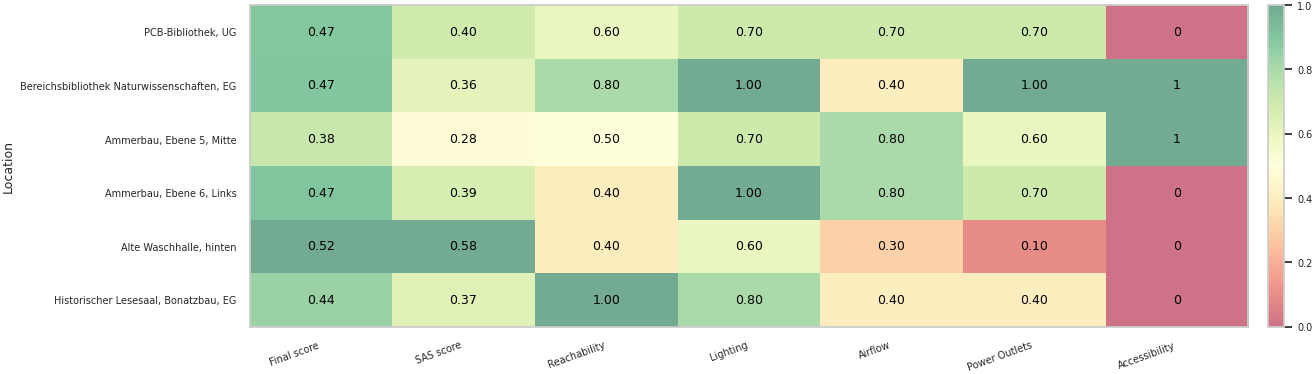

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tueplots import bundles
from seatadvisor_V3 import seat_advisor_locations

# -----------------------------
# Helper: pastel red -> green colormap
# -----------------------------
def pastelize_cmap(cmap_name: str = "RdYlGn", factor: float = 0.45) -> mpl.colors.ListedColormap:
    """
    factor in [0,1]: higher = more pastel (brighter / less saturated)
    """
    base = mpl.cm.get_cmap(cmap_name, 256)
    colors = base(np.linspace(0, 1, 256))
    colors[:, :3] = colors[:, :3] + (1 - colors[:, :3]) * factor
    return mpl.colors.ListedColormap(colors)

# -----------------------------
# User config
# -----------------------------
SELECTED_IDS = [19, 17, 10, 12, 16, 3, ]  # PCB UG, Bereichsbibliothek (hill) + Ammerbau/Waschhalle (valley)

SCENARIO = dict(
    campuses=[0, 1],
    weekday=None,               # any weekday
    time_of_day=None,           # any time of day
    exam_period=True,           # set False if you want non-exam weeks
    availability_threshold=0.15,
    user_is_hill=None,          # no distance penalty
    require_accessible=False,
    prior_weights=(0.25, 0.25, 0.25, 0.25),  # equal prior weights; lambda fixed in code (0.25)
)

MIN_OBS = 200

# -----------------------------
# 1) Run SeatAdvisor once
# -----------------------------
res_all = seat_advisor_locations(
    data=df,             # must contain t10, building_id, location_id, is_hill, relative_availability
    priors=priors_dict,  # from load_priors_csv("priors.csv")
    acc=acc_dict,        # from load_priors_csv("priors.csv")
    min_obs=MIN_OBS,
    topn=None,
    **SCENARIO,
)

# -----------------------------
# 2) Filter to selected locations and sanity checks
# -----------------------------
res = res_all[res_all["location_id"].isin(SELECTED_IDS)].copy()

print("Matched locations (ID -> name):")
print(
    res[["location_id", "location_name", "building_name"]]
    .sort_values("location_id")
    .to_string(index=False)
)

missing = [i for i in SELECTED_IDS if i not in set(res["location_id"])]
if missing:
    raise ValueError(
        f"These location_ids were not returned (likely < min_obs={MIN_OBS} under the chosen scenario): {missing}\n"
        f"Try lowering min_obs or changing exam_period."
    )

# Enforce the order specified by SELECTED_IDS
id_to_name = res.set_index("location_id")["location_name"].to_dict()
ordered_names = [id_to_name[i] for i in SELECTED_IDS]
res = res.set_index("location_name").loc[ordered_names].reset_index()

# -----------------------------
# 3) Build scorecard (true values)
# -----------------------------
scorecard = pd.DataFrame({
    "Location": res["location_name"].astype(str).values,

    # core scores
    "Final score": res["final_score"].astype(float).values,
    "SAS score":   res["sas_score"].astype(float).values,

    # priors (0..1, from priors.csv)
    "Reachability":  res["location_id"].map(lambda i: float(priors_dict[int(i)]["reach"])).values,
    "Lighting":      res["location_id"].map(lambda i: float(priors_dict[int(i)]["light"])).values,
    "Airflow":       res["location_id"].map(lambda i: float(priors_dict[int(i)]["air"])).values,
    "Power Outlets": res["location_id"].map(lambda i: float(priors_dict[int(i)]["outlet"])).values,

    # accessibility strictly 0/1
    "Accessibility": res["location_id"].map(lambda i: int(acc_dict.get(int(i), 0))).values,
}).set_index("Location")

# Ensure ranges / types (Final & SAS might not hit 1.0; keep true values unchanged here)
cont_cols = ["Final score", "SAS score", "Reachability", "Lighting", "Airflow", "Power Outlets"]
scorecard[cont_cols] = scorecard[cont_cols].apply(pd.to_numeric, errors="coerce").clip(0, 1)
scorecard["Accessibility"] = scorecard["Accessibility"].astype(int).clip(0, 1)

# -----------------------------
# 4) Build plot values for coloring (normalize Final & SAS to their own max, for comparable color use)
#    IMPORTANT: Annotations still show true values from scorecard.
# -----------------------------
plot_vals = scorecard.to_numpy(dtype=float).copy()
cols = list(scorecard.columns)

def _normalize_column_inplace(arr: np.ndarray, col_index: int) -> float:
    mx = float(np.nanmax(arr[:, col_index]))
    if mx > 0:
        arr[:, col_index] = arr[:, col_index] / mx
    return mx

final_idx = cols.index("Final score")
sas_idx   = cols.index("SAS score")

final_max = _normalize_column_inplace(plot_vals, final_idx)
sas_max   = _normalize_column_inplace(plot_vals, sas_idx)

# (priors already 0..1, accessibility 0/1; leave them as-is)

# -----------------------------
# 5) Plot heatmap (pastel red -> green)
# -----------------------------
plt.rcParams.update(bundles.neurips2023())
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "DejaVu Sans",
})

cmap = pastelize_cmap("RdYlGn", factor=0.45)

fig, ax = plt.subplots(figsize=(13.2, 3.8), layout="constrained")
im = ax.imshow(plot_vals, cmap=cmap, vmin=0, vmax=1, aspect="auto")

#ax.set_title("SeatAdvisor scorecard (any weekday/time; λ=0.25; pastel red → green)")
ax.set_ylabel("Location")

ax.set_xticks(range(scorecard.shape[1]))
ax.set_xticklabels(scorecard.columns, rotation=20, ha="right")

ax.set_yticks(range(scorecard.shape[0]))
ax.set_yticklabels(scorecard.index)

ax.grid(False)


# annotate with TRUE values (not normalized)
for i in range(scorecard.shape[0]):
    for j in range(scorecard.shape[1]):
        v_true = scorecard.values[i, j]
        if np.isfinite(v_true):
            col = scorecard.columns[j]
            if col == "Accessibility":
                label = f"{int(v_true)}"
            else:
                label = f"{v_true:.2f}"
            ax.text(j, i, label, ha="center", va="center", color="black", fontsize=9)

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
#cbar.set_label("Color scale: 0–1 (red → green). SAS & Final are color-normalized by their column maxima.")


# Optional note in the console (useful for caption/methods)
# print(f"\nColor normalization info:")
# print(f"  Final score max among selected locations: {final_max:.3f} (colors use Final/final_max)")
# print(f"  SAS score max among selected locations:   {sas_max:.3f} (colors use SAS/sas_max)")

plt.savefig("prior_heatmap_plot3.pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()


/var/folders/st/_29vlc0158l324jr2qbhlz3w0000gn/T/ipykernel_29929/4164339799.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = mpl.cm.get_cmap(cmap_name, 256)


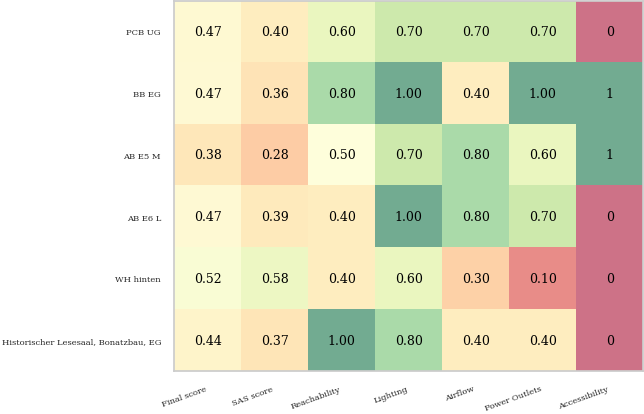

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tueplots import bundles
from seatadvisor_V3 import seat_advisor_locations

# -----------------------------
# Helper: pastel red -> green colormap
# -----------------------------
def pastelize_cmap(cmap_name: str = "RdYlGn", factor: float = 0.45) -> mpl.colors.ListedColormap:
    """
    factor in [0,1]: higher = more pastel (brighter / less saturated)
    """
    base = mpl.cm.get_cmap(cmap_name, 256)
    colors = base(np.linspace(0, 1, 256))
    colors[:, :3] = colors[:, :3] + (1 - colors[:, :3]) * factor
    return mpl.colors.ListedColormap(colors)

# -----------------------------
# User config
# -----------------------------
SELECTED_IDS = [19, 17, 10, 12, 16, 3]

SCENARIO = dict(
    campuses=[0, 1],
    weekday=None,
    time_of_day=None,
    exam_period=True,
    availability_threshold=0.15,
    user_is_hill=None,
    require_accessible=False,
    prior_weights=(0.25, 0.25, 0.25, 0.25),
)

MIN_OBS = 200

# -----------------------------
# 1) Run SeatAdvisor once
# -----------------------------
res_all = seat_advisor_locations(
    data=df,
    priors=priors_dict,
    acc=acc_dict,
    min_obs=MIN_OBS,
    topn=None,
    **SCENARIO,
)

# -----------------------------
# 2) Filter & order locations
# -----------------------------
res = res_all[res_all["location_id"].isin(SELECTED_IDS)].copy()

missing = [i for i in SELECTED_IDS if i not in set(res["location_id"])]
if missing:
    raise ValueError(f"Missing locations (min_obs too high?): {missing}")

id_to_name = res.set_index("location_id")["location_name"].to_dict()
ordered_names = [id_to_name[i] for i in SELECTED_IDS]
res = res.set_index("location_name").loc[ordered_names].reset_index()

# -----------------------------
# 3) Build scorecard (true values)
# -----------------------------
scorecard = pd.DataFrame({
    "Location": res["location_name"].astype(str).values,

    "Final score": res["final_score"].astype(float).values,
    "SAS score":   res["sas_score"].astype(float).values,

    "Reachability":  res["location_id"].map(lambda i: priors_dict[int(i)]["reach"]).values,
    "Lighting":      res["location_id"].map(lambda i: priors_dict[int(i)]["light"]).values,
    "Airflow":       res["location_id"].map(lambda i: priors_dict[int(i)]["air"]).values,
    "Power Outlets": res["location_id"].map(lambda i: priors_dict[int(i)]["outlet"]).values,

    "Accessibility": res["location_id"].map(lambda i: int(acc_dict.get(int(i), 0))).values,
}).set_index("Location")

cont_cols = ["Final score", "SAS score", "Reachability", "Lighting", "Airflow", "Power Outlets"]
scorecard[cont_cols] = scorecard[cont_cols].apply(pd.to_numeric).clip(0, 1)
scorecard["Accessibility"] = scorecard["Accessibility"].astype(int).clip(0, 1)

# -----------------------------
# 4) Shortened labels (OPTION B)
# -----------------------------
SHORT_NAMES = {
    "PCB-Bibliothek, UG": "PCB UG",
    "Bereichsbibliothek Naturwissenschaften, EG": "BB EG",
    "Ammerbau, Ebene 5, Mitte": "AB E5 M",
    "Ammerbau, Ebene 6, Links": "AB E6 L",
    "Alte Waschhalle, hinten": "WH hinten",
    "Ammerbau, Ebene 3, Rechts": "AB E3 R",
}

scorecard.index = [SHORT_NAMES.get(name, name) for name in scorecard.index]

plot_vals = scorecard.to_numpy(dtype=float)

# -----------------------------
# 5) Plot (one-column, paper-ready)
# -----------------------------
plt.rcParams.update(bundles.icml2024(column="half", nrows=1, ncols=1))
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "mathtext.fontset": "stix",
})

cmap = pastelize_cmap("RdYlGn", factor=0.45)

fig, ax = plt.subplots(figsize=(6.5, 4.2), layout="constrained")
ax.grid(False)

im = ax.imshow(plot_vals, cmap=cmap, vmin=0, vmax=1, aspect="auto")

ax.set_ylabel("")

ax.set_xticks(range(scorecard.shape[1]))
ax.set_xticklabels(scorecard.columns, rotation=20, ha="right")

ax.set_yticks(range(scorecard.shape[0]))
ax.set_yticklabels(scorecard.index)

# annotate with TRUE values (not normalized)
for i in range(scorecard.shape[0]):
    for j in range(scorecard.shape[1]):
        v_true = scorecard.values[i, j]
        if np.isfinite(v_true):
            col = scorecard.columns[j]
            if col == "Accessibility":
                label = f"{int(v_true)}"
            else:
                label = f"{v_true:.2f}"
            ax.text(j, i, label, ha="center", va="center",
                    color="black", fontsize=9)


# Save for LaTeX
fig.savefig("prior_heatmap_plot3.pdf", bbox_inches="tight", pad_inches=0.02)
plt.show()


/var/folders/st/_29vlc0158l324jr2qbhlz3w0000gn/T/ipykernel_29929/3610866583.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = mpl.cm.get_cmap(cmap_name, 256)


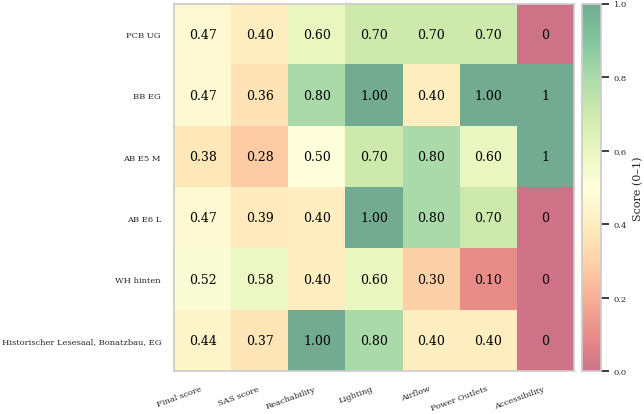

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tueplots import bundles
from seatadvisor_V3 import seat_advisor_locations

# -----------------------------
# Helper: pastel red -> green colormap
# -----------------------------
def pastelize_cmap(cmap_name: str = "RdYlGn", factor: float = 0.45) -> mpl.colors.ListedColormap:
    """
    factor in [0,1]: higher = more pastel (brighter / less saturated)
    """
    base = mpl.cm.get_cmap(cmap_name, 256)
    colors = base(np.linspace(0, 1, 256))
    colors[:, :3] = colors[:, :3] + (1 - colors[:, :3]) * factor
    return mpl.colors.ListedColormap(colors)

# -----------------------------
# User config
# -----------------------------
SELECTED_IDS = [19, 17, 10, 12, 16, 3]

SCENARIO = dict(
    campuses=[0, 1],
    weekday=None,
    time_of_day=None,
    exam_period=True,
    availability_threshold=0.15,
    user_is_hill=None,
    require_accessible=False,
    prior_weights=(0.25, 0.25, 0.25, 0.25),
)

MIN_OBS = 200

# -----------------------------
# 1) Run SeatAdvisor once
# -----------------------------
res_all = seat_advisor_locations(
    data=df,
    priors=priors_dict,
    acc=acc_dict,
    min_obs=MIN_OBS,
    topn=None,
    **SCENARIO,
)

# -----------------------------
# 2) Filter & order locations
# -----------------------------
res = res_all[res_all["location_id"].isin(SELECTED_IDS)].copy()

missing = [i for i in SELECTED_IDS if i not in set(res["location_id"])]
if missing:
    raise ValueError(f"Missing locations (min_obs too high?): {missing}")

id_to_name = res.set_index("location_id")["location_name"].to_dict()
ordered_names = [id_to_name[i] for i in SELECTED_IDS]
res = res.set_index("location_name").loc[ordered_names].reset_index()

# -----------------------------
# 3) Build scorecard (TRUE values, no normalization)
# -----------------------------
scorecard = pd.DataFrame({
    "Location": res["location_name"].astype(str).values,

    "Final score": res["final_score"].astype(float).values,
    "SAS score":   res["sas_score"].astype(float).values,

    "Reachability":  res["location_id"].map(lambda i: float(priors_dict[int(i)]["reach"])).values,
    "Lighting":      res["location_id"].map(lambda i: float(priors_dict[int(i)]["light"])).values,
    "Airflow":       res["location_id"].map(lambda i: float(priors_dict[int(i)]["air"])).values,
    "Power Outlets": res["location_id"].map(lambda i: float(priors_dict[int(i)]["outlet"])).values,

    "Accessibility": res["location_id"].map(lambda i: int(acc_dict.get(int(i), 0))).values,
}).set_index("Location")

# Force legal ranges (defined scale, not data normalization)
cont_cols = ["Final score", "SAS score", "Reachability", "Lighting", "Airflow", "Power Outlets"]
scorecard[cont_cols] = scorecard[cont_cols].apply(pd.to_numeric, errors="coerce").clip(0, 1)
scorecard["Accessibility"] = scorecard["Accessibility"].astype(int).clip(0, 1)

# -----------------------------
# 4) Shortened labels (Option B)
# -----------------------------
SHORT_NAMES = {
    "PCB-Bibliothek, UG": "PCB UG",
    "Bereichsbibliothek Naturwissenschaften, EG": "BB EG",
    "Ammerbau, Ebene 5, Mitte": "AB E5 M",
    "Ammerbau, Ebene 6, Links": "AB E6 L",
    "Alte Waschhalle, hinten": "WH hinten",
    "Ammerbau, Ebene 3, Rechts": "AB E3 R",
    "Historischer Lesesaal, EG": "HB EG"
}
scorecard.index = [SHORT_NAMES.get(name, name) for name in scorecard.index]

plot_vals = scorecard.to_numpy(dtype=float)

# -----------------------------
# 5) Plot (one-column, paper-ready)
# -----------------------------
plt.rcParams.update(bundles.icml2024(column="half", nrows=1, ncols=1))
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "mathtext.fontset": "stix",
})

cmap = pastelize_cmap("RdYlGn", factor=0.45)

fig, ax = plt.subplots(figsize=(6.5, 4.2), layout="constrained")
ax.grid(False)

# Fixed 0–1 scale (NO normalization)
im = ax.imshow(plot_vals, cmap=cmap, vmin=0, vmax=1, aspect="auto")

ax.set_ylabel("")
ax.set_xticks(range(scorecard.shape[1]))
ax.set_xticklabels(scorecard.columns, rotation=20, ha="right")

ax.set_yticks(range(scorecard.shape[0]))
ax.set_yticklabels(scorecard.index)

# -----------------------------
# Annotations (TRUE values)
# -----------------------------
for i in range(scorecard.shape[0]):
    for j in range(scorecard.shape[1]):
        v_true = scorecard.values[i, j]
        if np.isfinite(v_true):
            col = scorecard.columns[j]
            if col == "Accessibility":
                label = f"{int(v_true)}"
            else:
                label = f"{v_true:.2f}"
            ax.text(j, i, label, ha="center", va="center",
                    color="black", fontsize=9)

# -----------------------------
# Colorbar
# -----------------------------
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
cbar.set_label("Score (0–1)")

# Save for LaTeX
fig.savefig("prior_heatmap_plot3.pdf", bbox_inches="tight", pad_inches=0.02)
plt.show()
